# Here is the Step6 about SHD Dataset

使用 spike count 训练一个 ANN（如 MLP）

实验目的：
探索：在不使用 spike 时间信息的情况下，是否仍然可以从 firing rate中获得高分类性能。

操作方式：
- 对每个样本，统计每个神经元在整个时间窗口内的spike 次数 → 得到一个向量 (num_neurons,)；
- 用这些 spike count 作为特征输入；
- 用一个简单的 MLP 进行训练和测试；
- 比较：
  - 原始数据（全部神经元、所有 spike）；
  - 保留子集神经元（如你之前用的 224 个）；
  - 保留神经元 + 归一化 spike 总数的版本（控制输入信息量）。

背后逻辑：
- 如果只用 spike count 就能获得较好准确率 → 表明数据中包含大量 **rate-coded 信息**；
- 如果准确率大幅下降 → 说明模型依赖timing-coded 信息（即 spike 何时发生）。

预期现象：
- 在原始数据上表现较好；
- 在时间结构被扰动的数据上表现也可能不变；
- 如果性能接近 SNN 的结果，说明 rate 是主导因素。

In [1]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy import io
from utils import get_shd_dataset

# -------------------- 1. 加载 SHD 原始数据 --------------------
cache_dir = "D:/forStudy/IRP/IRP_Neuro_SNN/dataset"
cache_subdir = "hdspikes"
get_shd_dataset(cache_dir, cache_subdir)

base_path = os.path.join(cache_dir, cache_subdir)
train_path = os.path.join(base_path, "shd_train.h5")
test_path = os.path.join(base_path, "shd_test.h5")

train_file = h5py.File(train_path, "r")
test_file = h5py.File(test_path, "r")

x_train = train_file['spikes']
y_train = train_file['labels']
x_test = test_file['spikes']
y_test = test_file['labels']

batch_size = 256
nb_steps = 100
nb_units = 700
max_time = 1.4

def sparse_data_generator_from_hdf5_spikes(X, y, batch_size, nb_steps, nb_units, max_time, shuffle=True):
    labels_ = np.array(y, dtype=np.int32)
    number_of_batches = len(labels_) // batch_size
    sample_index = np.arange(len(labels_))
    firing_times = X['times']
    units_fired = X['units']
    time_bins = np.linspace(0, max_time, num=nb_steps)

    if shuffle:
        np.random.shuffle(sample_index)

    counter = 0
    while counter < number_of_batches:
        batch_index = sample_index[batch_size * counter : batch_size * (counter + 1)]
        dense_batch = np.zeros((batch_size, nb_units, nb_steps), dtype=np.uint8)
        y_batch = []

        for bc, idx in enumerate(batch_index):
            times = np.digitize(firing_times[idx], time_bins)
            units = units_fired[idx]
            times[times >= nb_steps] = nb_steps - 1
            dense_batch[bc, units, times] = 1
            y_batch.append(labels_[idx])

        yield dense_batch, np.array(y_batch, dtype=np.uint8)
        counter += 1

def collect_all(X_h5, Y_h5):
    X_all = []
    Y_all = []
    gen = sparse_data_generator_from_hdf5_spikes(X_h5, Y_h5,
                                                 batch_size, nb_steps,
                                                 nb_units, max_time,
                                                 shuffle=False)
    for x_batch, y_batch in gen:
        X_all.append(x_batch)
        Y_all.append(y_batch)
    X_all = np.concatenate(X_all, axis=0)
    Y_all = np.concatenate(Y_all, axis=0)
    return X_all, Y_all

X_train_all, Y_train_all = collect_all(x_train, y_train)
X_test_all,  Y_test_all  = collect_all(x_test,  y_test)

X_all = np.concatenate([X_train_all, X_test_all], axis=0)
Y_all = np.concatenate([Y_train_all, Y_test_all], axis=0)

# 保存完整数据集
io.savemat("spikedata6_whole_ori.mat", {"X": X_all, "Y": Y_all})
print("✅ Saved: spikedata6_whole_ori.mat")

# -------------------- 2. 创建 min-count 数据集 --------------------
def do_min_count(X, Y):
    N, F, T = X.shape
    count_all = X.sum(axis=2)
    min_counts = count_all.min(axis=0)

    X_min = np.zeros_like(X)
    for f_idx in range(F):
        N_f = min_counts[f_idx]
        if N_f == 0:
            continue
        for i_idx in range(N):
            spike_times = np.where(X[i_idx, f_idx, :] == 1)[0]
            if len(spike_times) > N_f:
                chosen_times = np.random.choice(spike_times, size=N_f, replace=False)
                X_min[i_idx, f_idx, chosen_times] = 1
            else:
                X_min[i_idx, f_idx, spike_times] = 1
    return X_min, Y

def create_min_count_dataset_avoid_widespread(X, Y, neuron_threshold=2, max_frac_for_neuron=0.01, max_samples_to_remove=1000):
    N, F, T = X.shape
    counts = X.sum(axis=2)
    min_counts_per_neuron = counts.min(axis=0)

    bad_neurons = np.where(min_counts_per_neuron < neuron_threshold)[0]
    print(f"Found {len(bad_neurons)} neurons with min_count < {neuron_threshold}.")

    if len(bad_neurons) == 0:
        return do_min_count(X, Y)

    samples_to_remove = set()
    for f_idx in bad_neurons:
        neuron_counts = counts[:, f_idx]
        i_bad = np.where(neuron_counts < neuron_threshold)[0]
        frac = len(i_bad) / N
        if frac <= max_frac_for_neuron:
            samples_to_remove.update(i_bad)

    if 0 < len(samples_to_remove) < max_samples_to_remove:
        keep_idxs = np.setdiff1d(np.arange(N), list(samples_to_remove))
        X_filtered = X[keep_idxs]
        Y_filtered = Y[keep_idxs]
        print(f"Removing {len(samples_to_remove)} samples.")
    else:
        X_filtered = X
        Y_filtered = Y
        print("NOT removing any samples.")

    return do_min_count(X_filtered, Y_filtered)

X_min, Y_min = create_min_count_dataset_avoid_widespread(
    X_all, Y_all,
    neuron_threshold=2,
    max_frac_for_neuron=0.01,
    max_samples_to_remove=2000
)

sum_over_samples_time = X_min.sum(axis=(0, 2))
zero_mask = (sum_over_samples_time == 0)
non_zero_mask = ~zero_mask

X_norm = X_min[:, non_zero_mask, :]
print(f"✅ After min-count + drop zero neurons => X_norm.shape = {X_norm.shape}")

io.savemat("spikedata6_norm_ori.mat", {"X": X_norm, "Y": Y_min})
print("✅ Saved: spikedata6_norm_ori.mat")

# -------------------- 3. 创建 part 子集但不做 min-count --------------------
X_part = X_all[:, non_zero_mask, :]  # 只保留相同神经元，但保留原始 spike
io.savemat("spikedata6_part_ori.mat", {"X": X_part, "Y": Y_all})
print("✅ Saved: spikedata6_part_ori.mat")


Available at: D:/forStudy/IRP/IRP_Neuro_SNN/dataset\hdspikes\shd_train.h5
Available at: D:/forStudy/IRP/IRP_Neuro_SNN/dataset\hdspikes\shd_test.h5
✅ Saved: spikedata6_whole_ori.mat
Found 691 neurons with min_count < 2.
Removing 1037 samples.
✅ After min-count + drop zero neurons => X_norm.shape = (8947, 224, 100)
✅ Saved: spikedata6_norm_ori.mat
✅ Saved: spikedata6_part_ori.mat


In [1]:
import numpy as np
import scipy.io as io
import os

def balance_dataset(input_path, output_path):
    """
    对指定 .mat 数据集做类别平衡，并保存为 output_path
    """
    print(f"\nProcessing: {input_path}")
    data = io.loadmat(input_path)
    X_full = data["X"]
    Y_full = data["Y"].ravel()
    N, num_neurons, T = X_full.shape

    print(f"Loaded dataset: X.shape=({N},{num_neurons},{T}), Y.shape=({len(Y_full)})")

    # 统计每类样本数
    unique_labels = np.unique(Y_full)
    counts_per_class = {c: np.sum(Y_full == c) for c in unique_labels}
    min_count = min(counts_per_class.values())

    print("--- Sample counts per class ---")
    for c in sorted(unique_labels):
        print(f"Class {c}: {counts_per_class[c]} samples")
    print(f"Using min_count = {min_count}")

    # 对每类裁剪样本数
    X_list = []
    Y_list = []
    for c in sorted(unique_labels):
        idxs_c = np.where(Y_full == c)[0]
        np.random.shuffle(idxs_c)
        selected = idxs_c[:min_count]
        X_list.append(X_full[selected])
        Y_list.append(Y_full[selected])

    X_bal = np.concatenate(X_list, axis=0)
    Y_bal = np.concatenate(Y_list, axis=0)

    # 全局打乱
    perm = np.random.permutation(len(Y_bal))
    X_bal = X_bal[perm]
    Y_bal = Y_bal[perm]

    print(f"Final balanced shape: X={X_bal.shape}, Y={Y_bal.shape}")
    io.savemat(output_path, {"X": X_bal, "Y": Y_bal})
    print(f"Saved balanced dataset to: {output_path}")


# ========== 对三个原始数据集分别进行平衡 ==========
datasets = [
    ("spikedata6_part_ori.mat",  "spikedata6_part.mat"),
    ("spikedata6_norm_ori.mat",  "spikedata6_norm.mat"),
]

for input_file, output_file in datasets:
    if os.path.exists(input_file):
        balance_dataset(input_file, output_file)
    else:
        print(f"File not found: {input_file}")



Processing: spikedata6_part_ori.mat
Loaded dataset: X.shape=(9984,224,100), Y.shape=(9984)
--- Sample counts per class ---
Class 0: 488 samples
Class 1: 483 samples
Class 2: 481 samples
Class 3: 502 samples
Class 4: 486 samples
Class 5: 495 samples
Class 6: 487 samples
Class 7: 485 samples
Class 8: 484 samples
Class 9: 487 samples
Class 10: 516 samples
Class 11: 512 samples
Class 12: 510 samples
Class 13: 502 samples
Class 14: 510 samples
Class 15: 513 samples
Class 16: 507 samples
Class 17: 511 samples
Class 18: 508 samples
Class 19: 517 samples
Using min_count = 481
Final balanced shape: X=(9620, 224, 100), Y=(9620,)
Saved balanced dataset to: spikedata6_part.mat

Processing: spikedata6_norm_ori.mat
Loaded dataset: X.shape=(8947,224,100), Y.shape=(8947)
--- Sample counts per class ---
Class 0: 474 samples
Class 1: 474 samples
Class 2: 273 samples
Class 3: 366 samples
Class 4: 462 samples
Class 5: 453 samples
Class 6: 372 samples
Class 7: 446 samples
Class 8: 385 samples
Class 9: 482

In [2]:
import pickle
import random
import numpy as np
from scipy import io
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as tnnf
from tqdm.notebook import tqdm
from utils import get_shd_dataset

ms = 1e-3 # use this constant so you can write e.g. 1*ms for a time

## Begin Here to Train

In [3]:
import numpy as np
import scipy.io as io
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

# ---------- Step 1: 加载平衡后的 spike count 数据 ----------
def load_dataset(mat_path):
    data = io.loadmat(mat_path)
    X = data["X"]  # shape: (N, num_neurons, T)
    Y = data["Y"].ravel()

    # 计算 spike count 向量：对时间求和
    X_count = X.sum(axis=2).astype(np.float32)  # shape: (N, num_neurons)
    return X_count, Y

# 选择其中一个数据集
X, Y = load_dataset("spikedata6_part.mat")
print(f"Loaded: X.shape = {X.shape}, Y.shape = {Y.shape}")

# ---------- Step 2: 划分训练集、验证集、测试集 ----------
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42, stratify=Y_temp)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

# ---------- Step 3: PyTorch Dataset & DataLoader ----------
from torch.utils.data import TensorDataset, DataLoader

batch_size = 64
train_loader = DataLoader(TensorDataset(torch.from_numpy(X_train), torch.from_numpy(Y_train)), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(TensorDataset(torch.from_numpy(X_val), torch.from_numpy(Y_val)), batch_size=batch_size)
test_loader  = DataLoader(TensorDataset(torch.from_numpy(X_test), torch.from_numpy(Y_test)), batch_size=batch_size)

num_classes = len(np.unique(Y))
input_dim = X.shape[1]

# ---------- Step 4: 定义简单的 MLP ----------
class SpikeMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, num_classes=20):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x):
        return self.model(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SpikeMLP(input_dim=input_dim, num_classes=num_classes).to(device)

# ---------- Step 5: 设置优化器、损失函数 ----------
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# ---------- Step 6: 训练函数 ----------
def evaluate(loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            preds = torch.argmax(logits, dim=1)
            correct += (preds == yb).sum().item()
            total += len(yb)
    return correct / total

# ---------- Step 7: 训练 MLP ----------
best_val_acc = 0.0
for epoch in range(1, 51):
    model.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

    # 验证准确率
    val_acc = evaluate(val_loader)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "mlp_best.pt")

    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch {epoch:3d} | Val Acc: {val_acc:.4f}")

# ---------- Step 8: 最终测试 ----------
model.load_state_dict(torch.load("mlp_best.pt"))
test_acc = evaluate(test_loader)
print(f"✅ Final Test Accuracy: {test_acc:.4f}")


Loaded: X.shape = (9620, 224), Y.shape = (9620,)
Train: (6734, 224), Val: (1443, 224), Test: (1443, 224)
Epoch   1 | Val Acc: 0.1497
Epoch  10 | Val Acc: 0.2682
Epoch  20 | Val Acc: 0.3125
Epoch  30 | Val Acc: 0.3541
Epoch  40 | Val Acc: 0.3416
Epoch  50 | Val Acc: 0.3645
✅ Final Test Accuracy: 0.3798



🔷 Training on: Whole (All neurons)
Epoch   1: Val Acc = 0.3238
Epoch  10: Val Acc = 0.6515
Epoch  20: Val Acc = 0.7076
Epoch  30: Val Acc = 0.7236
Epoch  40: Val Acc = 0.7009
Epoch  50: Val Acc = 0.7383

🔷 Training on: Part (224 neurons)
Epoch   1: Val Acc = 0.1143
Epoch  10: Val Acc = 0.2911
Epoch  20: Val Acc = 0.3202
Epoch  30: Val Acc = 0.3534
Epoch  40: Val Acc = 0.3493
Epoch  50: Val Acc = 0.3957

🔷 Training on: Norm (224 + min-count)
Epoch   1: Val Acc = 0.0501
Epoch  10: Val Acc = 0.0501
Epoch  20: Val Acc = 0.0501
Epoch  30: Val Acc = 0.0501
Epoch  40: Val Acc = 0.0488
Epoch  50: Val Acc = 0.0501


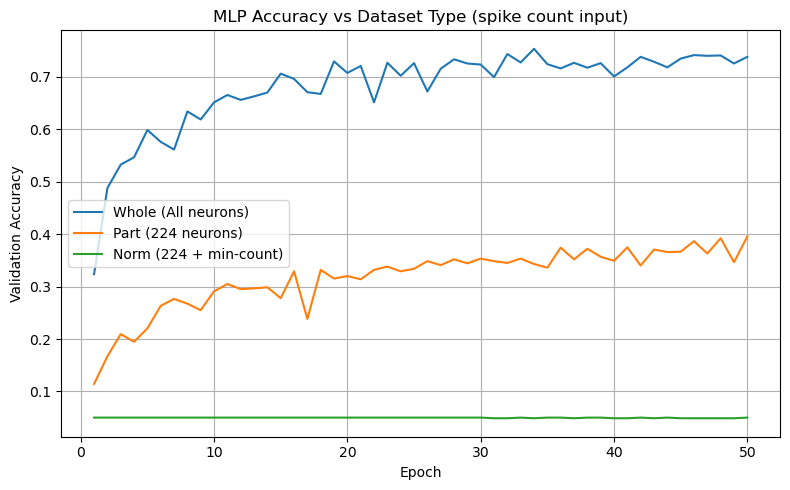

In [4]:
import numpy as np
import scipy.io as io
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

# ------------- 超参数配置 -------------
batch_size = 64
num_classes = 20
hidden_dim = 256
epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------- 定义 MLP 模型 -------------
class SpikeMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, num_classes=20):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x):
        return self.model(x)

# ------------- 加载 & 处理数据集 -------------
def load_count_dataset(mat_path):
    data = io.loadmat(mat_path)
    X = data["X"]  # shape = (N, F, T)
    Y = data["Y"].ravel()
    X_count = X.sum(axis=2).astype(np.float32)
    return X_count, Y

# ------------- 数据集配置 -------------
dataset_paths = {
    "Whole (All neurons)": "spikedata6_whole.mat",
    "Part (224 neurons)": "spikedata6_part.mat",
    "Norm (224 + min-count)": "spikedata6_norm.mat"
}

val_acc_curves = {}

# ------------- 主循环：依次训练三个数据集 -------------
for name, path in dataset_paths.items():
    print(f"\n🔷 Training on: {name}")
    X, Y = load_count_dataset(path)
    input_dim = X.shape[1]

    # 数据划分
    X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, stratify=Y, random_state=42)
    X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, stratify=Y_temp, random_state=42)

    train_loader = DataLoader(TensorDataset(torch.from_numpy(X_train), torch.from_numpy(Y_train)), batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(TensorDataset(torch.from_numpy(X_val), torch.from_numpy(Y_val)), batch_size=batch_size)
    test_loader  = DataLoader(TensorDataset(torch.from_numpy(X_test), torch.from_numpy(Y_test)), batch_size=batch_size)

    # 模型与优化器
    model = SpikeMLP(input_dim=input_dim, hidden_dim=hidden_dim, num_classes=num_classes).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    # 训练 + 验证
    val_acc_list = []
    best_val_acc = 0.0

    for epoch in range(1, epochs+1):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

        # 验证
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb).argmax(dim=1)
                correct += (preds == yb).sum().item()
                total += len(yb)
        val_acc = correct / total
        val_acc_list.append(val_acc)

        if epoch % 10 == 0 or epoch == 1:
            print(f"Epoch {epoch:3d}: Val Acc = {val_acc:.4f}")

    # 存储验证曲线
    val_acc_curves[name] = val_acc_list

# ------------- 绘制对比图 -------------
plt.figure(figsize=(8, 5))
for label, curve in val_acc_curves.items():
    plt.plot(range(1, epochs+1), curve, label=label)

plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("MLP Accuracy vs Dataset Type (spike count input)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
